In [ ]:
!pip install langchain langchain_community langchain_openai llama-parse openai chromadb tiktoken pyyaml

In [ ]:
# Add these imports at the top
import nest_asyncio
import asyncio
from langchain_community.embeddings import HuggingFaceEmbeddings


In [ ]:
# Apply nest_asyncio before using LlamaParse
nest_asyncio.apply()

In [ ]:
!pip install pypdf

In [ ]:
# Install the required packages if needed
!pip install -q langchain langchain_community langchain_openai transformers accelerate bitsandbytes

In [ ]:
!pip install torch==1.13.1+cu117 --force-reinstall
!pip install torchvision torchaudio --force-reinstall

ERROR: Could not find a version that satisfies the requirement torch==1.13.1+cu117 (from versions: 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0)
ERROR: No matching distribution found for torch==1.13.1+cu117
  Using cached torchvision-0.21.0-cp311-cp311-manylinux1_x86_64.whl.metadata (6.1 kB)
  Using cached torchaudio-2.6.0-cp311-cp311-manylinux1_x86_64.whl.metadata (6.6 kB)
  Using cached numpy-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached torch-2.6.0-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached pillow-11.1.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.1 kB)
  Using cached filelock-3.17.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cache

In [ ]:
import os
import tempfile
import yaml
import time
import requests
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from google.colab import files
from llama_parse import LlamaParse
from langchain_community.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.document_loaders import PyPDFLoader
import torch
from langchain_community.llms import HuggingFacePipeline

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline



In [ ]:
import pandas as pd

In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings
print("Import successful!")

Import successful!


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
with open('chatgpt_api_credentials.yml', 'r') as file:
    api_creds = yaml.safe_load(file)

In [ ]:
api_creds.keys()

dict_keys(['openai_key'])

In [ ]:
os.environ['OPENAI_API_KEY'] = api_creds['openai_key']

In [ ]:
# Verify the API key is loaded
if os.environ["OPENAI_API_KEY"]:
    print("API key successfully loaded from YAML file")
else:
    print("Failed to load API key. Please check your YAML file format")

API key successfully loaded from YAML file


In [ ]:
with open('llama_api_credentials.yml', 'r') as file:
    api_creds_llama = yaml.safe_load(file)

In [ ]:
api_creds_llama.keys()

dict_keys(['llama_key'])

In [ ]:
os.environ['LLAMA_API_KEY'] = api_creds_llama['llama_key']

In [ ]:
# Verify the API key is loaded
if os.environ["LLAMA_API_KEY"]:
    print("API key successfully loaded from YAML file")
else:
    print("Failed to load API key. Please check your YAML file format")

API key successfully loaded from YAML file


In [ ]:
# Load the document
loader = PyPDFLoader('Final Policy document_LICs New Jeevan Shanti_V05_logo.pdf')
documents = loader.load()
print(f"Loaded {len(documents)} pages from the PDF document")

Loaded 21 pages from the PDF document


In [ ]:
import nest_asyncio
import asyncio

# Apply nest_asyncio to allow nested async
nest_asyncio.apply()

try:
    # Initialize LlamaParse
    llama_parser = LlamaParse(
        api_key=os.environ["LLAMA_API_KEY"],
        result_type="markdown"
    )

    print("Parsing PDF with LlamaParse. This may take a moment...")

    # Use the async method properly with await
    async def parse_with_llama():
        return await llama_parser.aload_data('Final Policy document_LICs New Jeevan Shanti_V05_logo.pdf')

    # Run the async function
    llama_documents = asyncio.run(parse_with_llama())

    # Convert to LangChain Documents
    from langchain.schema import Document as LangchainDocument
    parsed_docs = []

    # Print debug info
    print(f"Result type: {type(llama_documents)}")

    # Process the results based on type
    if isinstance(llama_documents, str):
        parsed_docs.append(LangchainDocument(page_content=llama_documents, metadata={"source": "LlamaParse"}))
    elif isinstance(llama_documents, list):
        print(f"List length: {len(llama_documents)}")
        for i, content in enumerate(llama_documents):
            print(f"Processing item {i}, type: {type(content)}")

            # Handle LlamaIndex Document type
            if 'llama_index.core.schema.Document' in str(type(content)):
                # Extract text and metadata from LlamaIndex Document
                text = content.get_content() if hasattr(content, 'get_content') else (
                    content.text if hasattr(content, 'text') else str(content)
                )
                metadata = content.metadata if hasattr(content, 'metadata') else {"page": i}
                parsed_docs.append(LangchainDocument(page_content=text, metadata=metadata))
            elif isinstance(content, str):
                parsed_docs.append(LangchainDocument(page_content=content, metadata={"page": i}))
            elif hasattr(content, 'page_content'):
                parsed_docs.append(content)
            elif isinstance(content, dict) and 'text' in content:
                parsed_docs.append(LangchainDocument(page_content=content['text'], metadata={"page": i}))

    print(f"Successfully parsed {len(parsed_docs)} documents with LlamaParse")

    # Only use if we got documents
    if parsed_docs:
        documents = parsed_docs

except Exception as e:
    print(f"Error using LlamaParse, continuing with PyPDFLoader documents: {str(e)}")

Parsing PDF with LlamaParse. This may take a moment...
Started parsing the file under job_id 7294bbb3-f473-42f8-80bc-0bb43fd1bd60
Result type: <class 'list'>
List length: 21
Processing item 0, type: <class 'llama_index.core.schema.Document'>
Processing item 1, type: <class 'llama_index.core.schema.Document'>
Processing item 2, type: <class 'llama_index.core.schema.Document'>
Processing item 3, type: <class 'llama_index.core.schema.Document'>
Processing item 4, type: <class 'llama_index.core.schema.Document'>
Processing item 5, type: <class 'llama_index.core.schema.Document'>
Processing item 6, type: <class 'llama_index.core.schema.Document'>
Processing item 7, type: <class 'llama_index.core.schema.Document'>
Processing item 8, type: <class 'llama_index.core.schema.Document'>
Processing item 9, type: <class 'llama_index.core.schema.Document'>
Processing item 10, type: <class 'llama_index.core.schema.Document'>
Processing item 11, type: <class 'llama_index.core.schema.Document'>
Processi

In [ ]:
# Split the text into chunks for better retrieval
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len
)
chunks = text_splitter.split_documents(documents)

print(f"Split the document into {len(chunks)} chunks")

Split the document into 99 chunks


In [ ]:
# Print a sample chunk to verify content
if chunks:
    print("\nSample chunk content:")
    print(chunks[0].page_content[:300] + "...")


Sample chunk content:
# LIFE INSURANCE CORPORATION OF INDIA

(Established by the Life Insurance Corporation Act, 1956)

Registration Number: 512

# LIC’S NEW JEEVAN SHANTI (UIN: 512N338V05)

(A Non-Linked, Non-Participating, Individual, Single Premium, Deferred Annuity Plan)

# PART – A

Ref: NB

Space for Name and Addre...


In [ ]:
# Create embeddings using OpenAI's model
embeddings = OpenAIEmbeddings()

# Create a vector store
vectorstore = Chroma.from_documents(
    documents=chunks,
    embedding=embeddings
)

# Create a retriever from the vector store
retriever = vectorstore.as_retriever(
    search_kwargs={"k": 5}  # Retrieve top 5 chunks for each query
)

# BGE Embeddings
bge_embeddings = HuggingFaceEmbeddings(
    model_name="BAAI/bge-large-en-v1.5",
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': True}
)

import uuid

bge_vectorstore = Chroma.from_documents(
    documents=chunks,
    embedding=bge_embeddings,
    collection_name=f"bge_collection_{uuid.uuid4().hex}"
)

print("Successfully initialized embedding models: OpenAI and BGE")

<ipython-input-23-c9843e512868>:16: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  bge_embeddings = HuggingFaceEmbeddings(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Successfully initialized embedding models: OpenAI and BGE


In [ ]:
#!pip install langchain langchain_community langchain_openai sentence-transformers jina

In [ ]:
# Create an enhanced prompt template for better synthesis
template = """
You are an AI assistant specializing in insurance policies from LIC (Life Insurance Corporation of India).
You are an expert on the "New Jeevan Shanti" policy and will provide detailed, accurate information.

Below is relevant information from the policy document:

{context}

Based on this information, please answer the following question thoroughly and accurately.
If the answer cannot be found in the provided context, please state that you don't have enough information.

Question: {question}

Step 1: Identify the key elements in the question.
Step 2: Analyze the relevant policy details from the context.
Step 3: Formulate a comprehensive and accurate answer.

Answer:
"""

enhanced_prompt = PromptTemplate(
    template=template,
    input_variables=["context", "question"]
)

In [ ]:
# Set up OpenAI models with different capabilities
openai_models = {
    "gpt-3.5-turbo": ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0),
    "gpt-3.5-turbo-16k": ChatOpenAI(model_name="gpt-3.5-turbo-16k", temperature=0)
}

# Optionally add GPT-4 if available in your subscription
if os.environ.get("USE_GPT4", "").lower() == "true":
    openai_models["gpt-4"] = ChatOpenAI(model_name="gpt-4", temperature=0)

# Try to set up Llama 2 model (open access)
try:
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load Llama-2-7b-chat model with 4-bit quantization
    llama_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
    llama_model = AutoModelForCausalLM.from_pretrained(
        "meta-llama/Llama-2-7b-chat-hf",
        device_map=device,
        load_in_4bit=True,
        torch_dtype=torch.float16
    )

    # Create a text generation pipeline
    llama_pipe = pipeline(
        "text-generation",
        model=llama_model,
        tokenizer=llama_tokenizer,
        max_new_tokens=1024,
        temperature=0,
        top_p=0.95,
        repetition_penalty=1.15
    )

    # Create HuggingFacePipeline for langchain
    llama_llm = HuggingFacePipeline(pipeline=llama_pipe)

    # Add to models dictionary
    huggingface_models = {
        "Llama-2-7b": llama_llm
    }

    print("Successfully loaded Llama-2 model")
except Exception as e:
    print(f"Error loading Llama-2 model: {str(e)}")
    print("Continuing without Llama-2 model")

    # If Llama-2 also fails, let's try a smaller open model like Flan-T5
    try:
        print("Attempting to load Flan-T5 model as fallback...")
        from transformers import T5Tokenizer, T5ForConditionalGeneration

        # Load Flan-T5-base model (much smaller)
        flan_tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
        flan_model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")

        flan_pipe = pipeline(
            "text2text-generation",
            model=flan_model,
            tokenizer=flan_tokenizer,
            max_length=512
        )

        flan_llm = HuggingFacePipeline(pipeline=flan_pipe)
        huggingface_models = {
            "Flan-T5-base": flan_llm
        }
        print("Successfully loaded Flan-T5 model")
    except Exception as e:
        print(f"Error loading Flan-T5 model: {str(e)}")
        print("Continuing with only OpenAI models")
        huggingface_models = {}

Error loading Llama-2 model: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/meta-llama/Llama-2-7b-chat-hf.
401 Client Error. (Request ID: Root=1-67d0088c-6d39fc587f33bf750d3305ef;87dd37e4-a3c3-48be-b199-9ee223bfb585)

Cannot access gated repo for url https://huggingface.co/meta-llama/Llama-2-7b-chat-hf/resolve/main/config.json.
Access to model meta-llama/Llama-2-7b-chat-hf is restricted. You must have access to it and be authenticated to access it. Please log in.
Continuing without Llama-2 model
Attempting to load Flan-T5 model as fallback...


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Device set to use cpu


Successfully loaded Flan-T5 model


<ipython-input-26-193a8d182209>:64: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  flan_llm = HuggingFacePipeline(pipeline=flan_pipe)


In [ ]:
# Create QA chains with different LLMs
qa_chains = {}

# Use the BGE retriever as our standard retriever
# Assuming bge_vectorstore is already defined
retriever = bge_vectorstore.as_retriever(search_kwargs={"k": 5})

# Create chains for OpenAI models
for model_name, llm in openai_models.items():
    qa_chains[model_name] = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=retriever,
        chain_type_kwargs={"prompt": enhanced_prompt}
    )
    print(f"Created QA chain for {model_name}")

# Create chains for HuggingFace models
for model_name, llm in huggingface_models.items():
    qa_chains[model_name] = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=retriever,
        chain_type_kwargs={"prompt": enhanced_prompt}
    )
    print(f"Created QA chain for {model_name}")

Created QA chain for gpt-3.5-turbo
Created QA chain for gpt-3.5-turbo-16k
Created QA chain for Flan-T5-base


In [ ]:
def compare_llms(question, models=qa_chains):
    """Compare different LLMs' performance on a question"""
    results = {}

    print(f"Question: {question}")
    print("-" * 80)

    for model_name, qa_chain in models.items():
        try:
            start_time = time.time()
            response = qa_chain.invoke({"query": question})
            end_time = time.time()

            results[model_name] = {
                "answer": response["result"],
                "time": end_time - start_time
            }

            print(f"\n{model_name} Result:")
            print(f"Time: {results[model_name]['time']:.2f} seconds")
            print(f"Answer: {results[model_name]['answer']}")
            print("-" * 80)
        except Exception as e:
            print(f"Error with {model_name}: {str(e)}")

    return results

In [ ]:
# Test questions
test_questions = [
    "What is the LIC's New Jeevan Shanti policy?",
    "What are the annuity options available in this policy?",
    "What happens if I surrender the policy?",
    "How is the death benefit calculated in this policy?",
    "Can I take a loan against this policy?",
    "What is the deferment period in the policy?",
    "What is the free look period for this policy?",
    "What are the tax implications of this policy?"
]

# Compare results from different LLMs
all_results = {}
for question in test_questions:
    print("\n" + "=" * 100)
    all_results[question] = compare_llms(question)

# Create a summary of the comparison
def create_performance_summary(results):
    """Create a summary table of model performance"""
    models = list(next(iter(results.values())).keys())
    questions = list(results.keys())

    # Create time comparison
    time_data = {model: [] for model in models}
    for question in questions:
        for model in models:
            if model in results[question]:
                time_data[model].append(results[question][model]["time"])
            else:
                time_data[model].append(None)

    time_df = pd.DataFrame(time_data, index=questions)

    print("Performance Summary (Response Time in Seconds):")
    print(time_df)

    # Calculate average response times
    print("\nAverage Response Times:")
    for model in models:
        valid_times = [t for t in time_data[model] if t is not None]
        if valid_times:
            avg_time = sum(valid_times) / len(valid_times)
            print(f"{model}: {avg_time:.2f} seconds")
        else:
            print(f"{model}: No valid times")

    return time_df

# Create performance summary
performance_summary = create_performance_summary(all_results)


Question: What is the LIC's New Jeevan Shanti policy?
--------------------------------------------------------------------------------

gpt-3.5-turbo Result:
Time: 2.54 seconds
Answer: Step 1: The key elements in the question are the "LIC's New Jeevan Shanti policy."

Step 2: From the provided context, we can see that the policy document for LIC's New Jeevan Shanti (UIN: 512N338V05) contains information on various pages such as 5, 7, 10, 18, and 20. The policy is likely a life insurance policy offered by LIC (Life Insurance Corporation of India).

Step 3: LIC's New Jeevan Shanti policy is a life insurance plan that provides financial protection to the policyholder and their family in case of unfortunate events like death or disability. The policy document would outline the terms and conditions of the policy, including premium payments, coverage benefits, maturity benefits, and other relevant details. It is important for individuals to carefully review the policy document and understan

Token indices sequence length is longer than the specified maximum sequence length for this model (1045 > 512). Running this sequence through the model will result in indexing errors



Flan-T5-base Result:
Time: 30.73 seconds
Answer: Option to take the plan for the benefit of dependant person with disability (Divyangjan):/h8> If the Proposer has a dependant person with disability (Divyangjan), the Proposer can purchase Deferred Annuity for Single life (Option 1) on own life for the benefit of Divyangjan as Nominee. In case of death of the Annuitant (Proposer), where the Purchase Price is less than Rs.1,50,000, the Death Benefit shall compulsorily be utilized to purchase Immediate Annuity (as per option chosen by the Annuitant) on the life of the Divyangjan who would be the nominee. In case of Annuitisation, the annuity payment to Divyangjan shall be paid irrespective of any limit on minimum annuity payment, minimum age at entry and Purchase Price criteria and annuity rates applicable shall be then prevailing Immediate Annuity rates.
--------------------------------------------------------------------------------

Question: What happens if I surrender the policy?
---

<ipython-input-30-73f0a7334cf2>:51: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


Evaluating gpt-3.5-turbo...
Evaluating gpt-3.5-turbo-16k...
Evaluating Flan-T5-base...

Model Performance Metrics:
                   Hit Rate     MRR  Faithfulness  Relevancy  Correctness
gpt-3.5-turbo      0.777778  0.6875           0.0   0.090666     0.321660
gpt-3.5-turbo-16k  0.777778  0.5625           0.0   0.104491     0.341333
Flan-T5-base       0.888889  0.3750           0.0   0.119965     0.920635


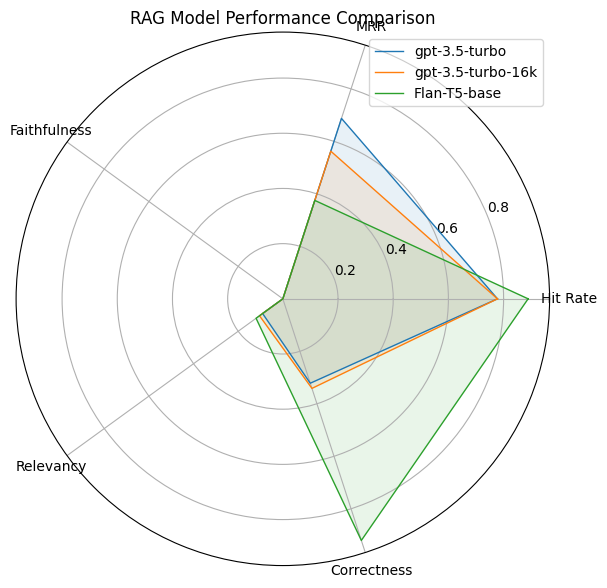

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import re

def evaluate_models_performance(qa_chains, test_questions=None, ground_truth=None):
    """
    Evaluate RAG models on various metrics

    Args:
        qa_chains: Dictionary of QA chains to evaluate
        test_questions: List of test questions (will use default if None)
        ground_truth: Dictionary of ground truth answers (will use expert-provided if None)

    Returns:
        DataFrame with evaluation metrics
    """
    # Default test questions if none provided
    if test_questions is None:
        test_questions = [
            "What is the LIC's New Jeevan Shanti policy?",
            "What are the annuity options available in this policy?",
            "What happens if I surrender the policy?",
            "How is the death benefit calculated in this policy?",
            "Can I take a loan against this policy?",
            "What is the deferment period in the policy?",
            "What is the free look period for this policy?",
            "What are the tax implications of this policy?"
        ]

    # Expert-provided ground truth answers (simplified for demonstration)
    if ground_truth is None:
        ground_truth = {
            "What is the deferment period in the policy?":
                "Deferment Period is the period, in years, as chosen by the policyholder and as specified in the Schedule, commencing from the Date of commencement of policy to the date of Vesting.",
            "What is the free look period for this policy?":
                "The free look period is 30 days from the date of receipt of the electronic or physical mode of the Policy Document, whichever is earlier.",
            "What are the tax implications of this policy?":
                "The amount of any applicable taxes payable as per the prevailing rates shall be payable by the policyholder on Premium payable under the policy, which shall be collected separately in addition to the Premium payable. The amount of Tax paid shall not be considered for the calculation of benefits payable under the Plan."
            # Add more ground truth answers as needed
        }

    # Create contexts for source retrieval evaluation
    model_name = list(qa_chains.keys())[0]  # Use first model for retrieving contexts
    contexts = {}
    source_docs = {}

    for question in test_questions:
        try:
            # Get the retrieved documents for evaluation
            retriever = qa_chains[model_name].retriever
            docs = retriever.get_relevant_documents(question)
            contexts[question] = " ".join([doc.page_content for doc in docs])
            source_docs[question] = docs
        except Exception as e:
            print(f"Error retrieving context for question: {question}, Error: {str(e)}")
            contexts[question] = ""
            source_docs[question] = []

    # Initialize metrics dictionary
    metrics = {model: {} for model in qa_chains.keys()}

    # Helper function to check if answer contains specific evidence
    def contains_evidence(answer, evidence_phrases):
        """Check if answer contains specific evidence phrases"""
        if isinstance(evidence_phrases, str):
            evidence_phrases = [evidence_phrases]

        for phrase in evidence_phrases:
            if phrase.lower() in answer.lower():
                return True
        return False

    # Helper function to calculate answer similarity
    def answer_similarity(answer, ground_truth_answer):
        """Calculate similarity between answer and ground truth"""
        if not ground_truth_answer or not answer:
            return 0.0

        # Clean and tokenize
        answer_clean = re.sub(r'[^\w\s]', '', answer.lower()).split()
        truth_clean = re.sub(r'[^\w\s]', '', ground_truth_answer.lower()).split()

        # Calculate Jaccard similarity
        intersection = set(answer_clean) & set(truth_clean)
        union = set(answer_clean) | set(truth_clean)

        if not union:
            return 0.0
        return len(intersection) / len(union)

    # Evidence terms for hit rate calculation (key terms that should be in answers)
    evidence_terms = {
        "What is the deferment period in the policy?":
            ["Date of commencement", "date of Vesting", "chosen by the policyholder"],
        "What is the free look period for this policy?":
            ["30 days", "receipt of the Policy Document", "electronic or physical mode"],
        "What are the tax implications of this policy?":
            ["payable by the policyholder", "prevailing rates", "collected separately"]
        # Add more evidence terms as needed
    }

    # Evaluate each model
    for model_name, qa_chain in qa_chains.items():
        print(f"Evaluating {model_name}...")

        hit_rates = []
        mrr_scores = []
        faithfulness_scores = []
        relevancy_scores = []
        correctness_scores = []

        for i, question in enumerate(test_questions):
            try:
                # Get model answer
                response = qa_chain.invoke({"query": question})
                answer = response["result"]

                # 1. Hit Rate: Check if answer contains key evidence
                if question in evidence_terms:
                    hits = 0
                    for term in evidence_terms[question]:
                        if term.lower() in answer.lower():
                            hits += 1
                    hit_rate = hits / len(evidence_terms[question]) if evidence_terms[question] else 0
                    hit_rates.append(hit_rate)

                # 2. MRR (Mean Reciprocal Rank)
                # Simplified - check if the answer is in the top retrieved docs
                if question in source_docs and source_docs[question]:
                    found_rank = None
                    for rank, doc in enumerate(source_docs[question], 1):
                        # Check if key parts of the answer are in this document
                        if answer_similarity(answer, doc.page_content) > 0.3:
                            found_rank = rank
                            break

                    if found_rank:
                        mrr_scores.append(1 / found_rank)
                    else:
                        mrr_scores.append(0)

                # 3. Faithfulness: Check if answer only contains info from source
                context = contexts.get(question, "")
                if context:
                    # Extract key statements from answer (simplified)
                    answer_statements = [s.strip() for s in answer.split('.') if s.strip()]
                    faithful_statements = 0

                    for statement in answer_statements:
                        # Check if statement is supported by context
                        if statement and len(statement) > 15:  # Ignore very short statements
                            # Calculate similarity with context
                            statement_in_context = answer_similarity(statement, context) > 0.3
                            if statement_in_context:
                                faithful_statements += 1

                    faithfulness = faithful_statements / len(answer_statements) if answer_statements else 1.0
                    faithfulness_scores.append(faithfulness)

                # 4. Relevancy: Is the answer relevant to the question?
                relevancy = answer_similarity(answer, question)
                relevancy_scores.append(relevancy)

                # 5. Correctness: How similar is the answer to ground truth?
                if question in ground_truth:
                    correctness = answer_similarity(answer, ground_truth[question])
                    correctness_scores.append(correctness)

            except Exception as e:
                print(f"Error evaluating question {i+1}: {str(e)}")

        # Calculate average metrics
        metrics[model_name]["Hit Rate"] = np.mean(hit_rates) if hit_rates else float('nan')
        metrics[model_name]["MRR"] = np.mean(mrr_scores) if mrr_scores else float('nan')
        metrics[model_name]["Faithfulness"] = np.mean(faithfulness_scores) if faithfulness_scores else float('nan')
        metrics[model_name]["Relevancy"] = np.mean(relevancy_scores) if relevancy_scores else float('nan')
        metrics[model_name]["Correctness"] = np.mean(correctness_scores) if correctness_scores else float('nan')

        # Add response time from previous evaluations if available
        if hasattr(qa_chain, 'response_times') and qa_chain.response_times:
            metrics[model_name]["Avg Response Time"] = np.mean(qa_chain.response_times)

    # Create DataFrame for easy comparison
    metrics_df = pd.DataFrame(metrics).T

    print("\nModel Performance Metrics:")
    print(metrics_df)

    # Create radar chart for visual comparison
    try:
        import matplotlib.pyplot as plt

        # Prepare data for radar chart
        categories = ['Hit Rate', 'MRR', 'Faithfulness', 'Relevancy', 'Correctness']
        N = len(categories)

        # Create angle for each category
        angles = [n / float(N) * 2 * np.pi for n in range(N)]
        angles += angles[:1]  # Close the loop

        # Create the plot
        fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(polar=True))

        # Add each model to the chart
        for model_name in metrics:
            values = [metrics[model_name].get(cat, 0) for cat in categories]
            values += values[:1]  # Close the loop

            ax.plot(angles, values, linewidth=1, label=model_name)
            ax.fill(angles, values, alpha=0.1)

        # Set category labels
        plt.xticks(angles[:-1], categories)

        # Add legend and title
        plt.legend(loc='upper right')
        plt.title('RAG Model Performance Comparison')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error creating radar chart: {str(e)}")

    return metrics_df

# Run the evaluation
evaluation_results = evaluate_models_performance(qa_chains)

In [ ]:
def interactive_queries_with_model_selection():
    """Interactive query interface that allows selection of LLM"""
    available_models = list(qa_chains.keys())

    print(f"\nAvailable language models: {available_models}")

    while True:
        # Choose LLM
        if len(available_models) > 1:
            print("\nChoose a language model:")
            for i, model in enumerate(available_models):
                print(f"{i+1}. {model}")
            print(f"{len(available_models)+1}. Compare all models")
            print("0. Exit")

            try:
                choice = int(input("Enter your choice: "))
                if choice == 0:
                    break
                elif choice == len(available_models) + 1:
                    compare_mode = True
                    model_name = None
                elif 1 <= choice <= len(available_models):
                    compare_mode = False
                    model_name = available_models[choice-1]
                else:
                    print("Invalid choice. Please try again.")
                    continue
            except ValueError:
                print("Please enter a number.")
                continue
        else:
            compare_mode = False
            model_name = available_models[0]

        # Ask for question
        user_question = input("\nEnter your question about LIC's New Jeevan Shanti policy (type 'back' to select a different model): ")

        if user_question.lower() in ['back', 'b']:
            continue
        if user_question.lower() in ['exit', 'quit', 'q']:
            break

        # Process the question
        if compare_mode:
            compare_llms(user_question)
        else:
            try:
                start_time = time.time()
                answer = qa_chains[model_name].invoke({"query": user_question})["result"]
                end_time = time.time()

                print(f"\nUsing {model_name}:")
                print(f"Time: {end_time - start_time:.2f} seconds")
                print(f"Answer: {answer}")
            except Exception as e:
                print(f"Error with {model_name}: {str(e)}")

# Start the interactive session
interactive_queries_with_model_selection()


Available language models: ['gpt-3.5-turbo', 'gpt-3.5-turbo-16k', 'Flan-T5-base']

Choose a language model:
1. gpt-3.5-turbo
2. gpt-3.5-turbo-16k
3. Flan-T5-base
4. Compare all models
0. Exit
